In [1]:
import math
import os
from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import ipywidgets as widgets
from IPython.display import display, clear_output

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False);

In [3]:
# COCO classes
COCO_CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

VOC_CLASSES = ["N/A","person","bird", "cat", "cow", "dog", "horse", "sheep",
               "aeroplane", "bicycle", "boat", "bus", "car", "motorbike", "train",
               "bottle", "chair", "dining table", "potted plant", "sofa", "tv/monitor" 
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [4]:
class_dict = {}
for i in VOC_CLASSES:
    class_dict[i] = []

In [5]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [6]:
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{COCO_CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [7]:
model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
model.eval();

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_main
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
import xml.etree.ElementTree as ET

def extract_objects(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    objects = []
    for obj in root.findall('object'):
        obj_name = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        if obj_name in VOC_CLASSES:
            objects.append({
                'name': obj_name,
                'bbox': [xmin, ymin, xmax, ymax]
            })
    return sorted(objects,key=lambda item: item['bbox'])

In [9]:
def get_results(pil_img, prob, boxes):
    colors = COLORS * 100
    objects = []
    counter=0
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        cl = p.argmax()
        if COCO_CLASSES[cl] in VOC_CLASSES:
            objects.append({
                'name': COCO_CLASSES[cl],
                'bbox': [round(xmin,2), round(ymin,2), round(xmax,2), round(ymax,2)],
                'score': prob[counter][cl]
            })
        counter+=1
    return sorted(objects,key=lambda item: item['bbox'])

In [10]:
def calculate_iou(box1, box2):
    # Calculate intersection coordinates
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # Calculate intersection area
    intersection_area = max(0, x2 - x1) * max(0, y2 - y1)

    # Calculate areas of bounding boxes
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Calculate union area
    union_area = box1_area + box2_area - intersection_area

    # Calculate IoU
    iou = intersection_area / union_area if union_area > 0 else 0
    return iou

def match_boxes(ground_truth, predicted):
    matches = {}
    for pred_box in predicted:
        max_iou = 0
        for gt_box in ground_truth:
            iou = calculate_iou(pred_box['bbox'], gt_box['bbox'])
            if iou > max_iou:
                max_iou = iou
                matches[pred_box] = gt_box
    return matches

def calculate_average_iou(extracted_objects, predicted_objects):
    iou_sum = 0
    total_objects = 0

    for gt_object in extracted_objects:
        gt_box = gt_object['bbox']
        max_iou = 0

        for pred_object in predicted_objects:
            pred_box = pred_object['bbox']
            iou = calculate_iou(gt_box, pred_box)
            if iou > max_iou:
                max_iou = iou

        iou_sum += max_iou
        total_objects += 1

    average_iou = iou_sum / total_objects if total_objects > 0 else 0
    return average_iou

# Example usage:
# avg_iou = calculate_average_iou(extracted_objects, get)
# print("Average IoU:", avg_iou)

counter = 0

avgs = []

for imgp in reversed(sorted(os.listdir("/kaggle/input/pascalvoc2012-val/VOC2012/JPEGImages"))):
    print(imgp)
    im = Image.open(f"/kaggle/input/pascalvoc2012-val/VOC2012/JPEGImages/{imgp}")
    temp = imgp.split('.')
    extracted_objects = extract_objects(f"/kaggle/input/pascalvoc2012-val/VOC2012/Annotations/{temp[0]+'.xml'}")
    print("GROUND TRUTH")
    for obj in extracted_objects:
        print(obj)
    img = transform(im).unsqueeze(0)
    outputs = model(img)
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.9
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    get = get_results(im, probas[keep], bboxes_scaled)
    print("PREDICTED")
    avgs.append(calculate_average_iou(extracted_objects, get))
    for x in get:
        print(x)
    counter+=1
    if counter==20:
        break
    break
print(sum(avgs)/len(avgs))

2012_004331.jpg
GROUND TRUTH
{'name': 'person', 'bbox': [102, 25, 208, 230]}
PREDICTED
{'name': 'person', 'bbox': [67.5, 0.01, 87.0, 7.67], 'score': tensor(0.9311)}
{'name': 'person', 'bbox': [98.61, 0.01, 111.35, 6.51], 'score': tensor(0.9252)}
{'name': 'person', 'bbox': [100.96, 25.79, 207.5, 227.79], 'score': tensor(0.9992)}
{'name': 'person', 'bbox': [236.87, 190.0, 448.07, 310.24], 'score': tensor(0.9996)}
{'name': 'person', 'bbox': [408.69, 0.0, 417.64, 4.91], 'score': tensor(0.9046)}
0.9713273607024222


2012_004331.jpg


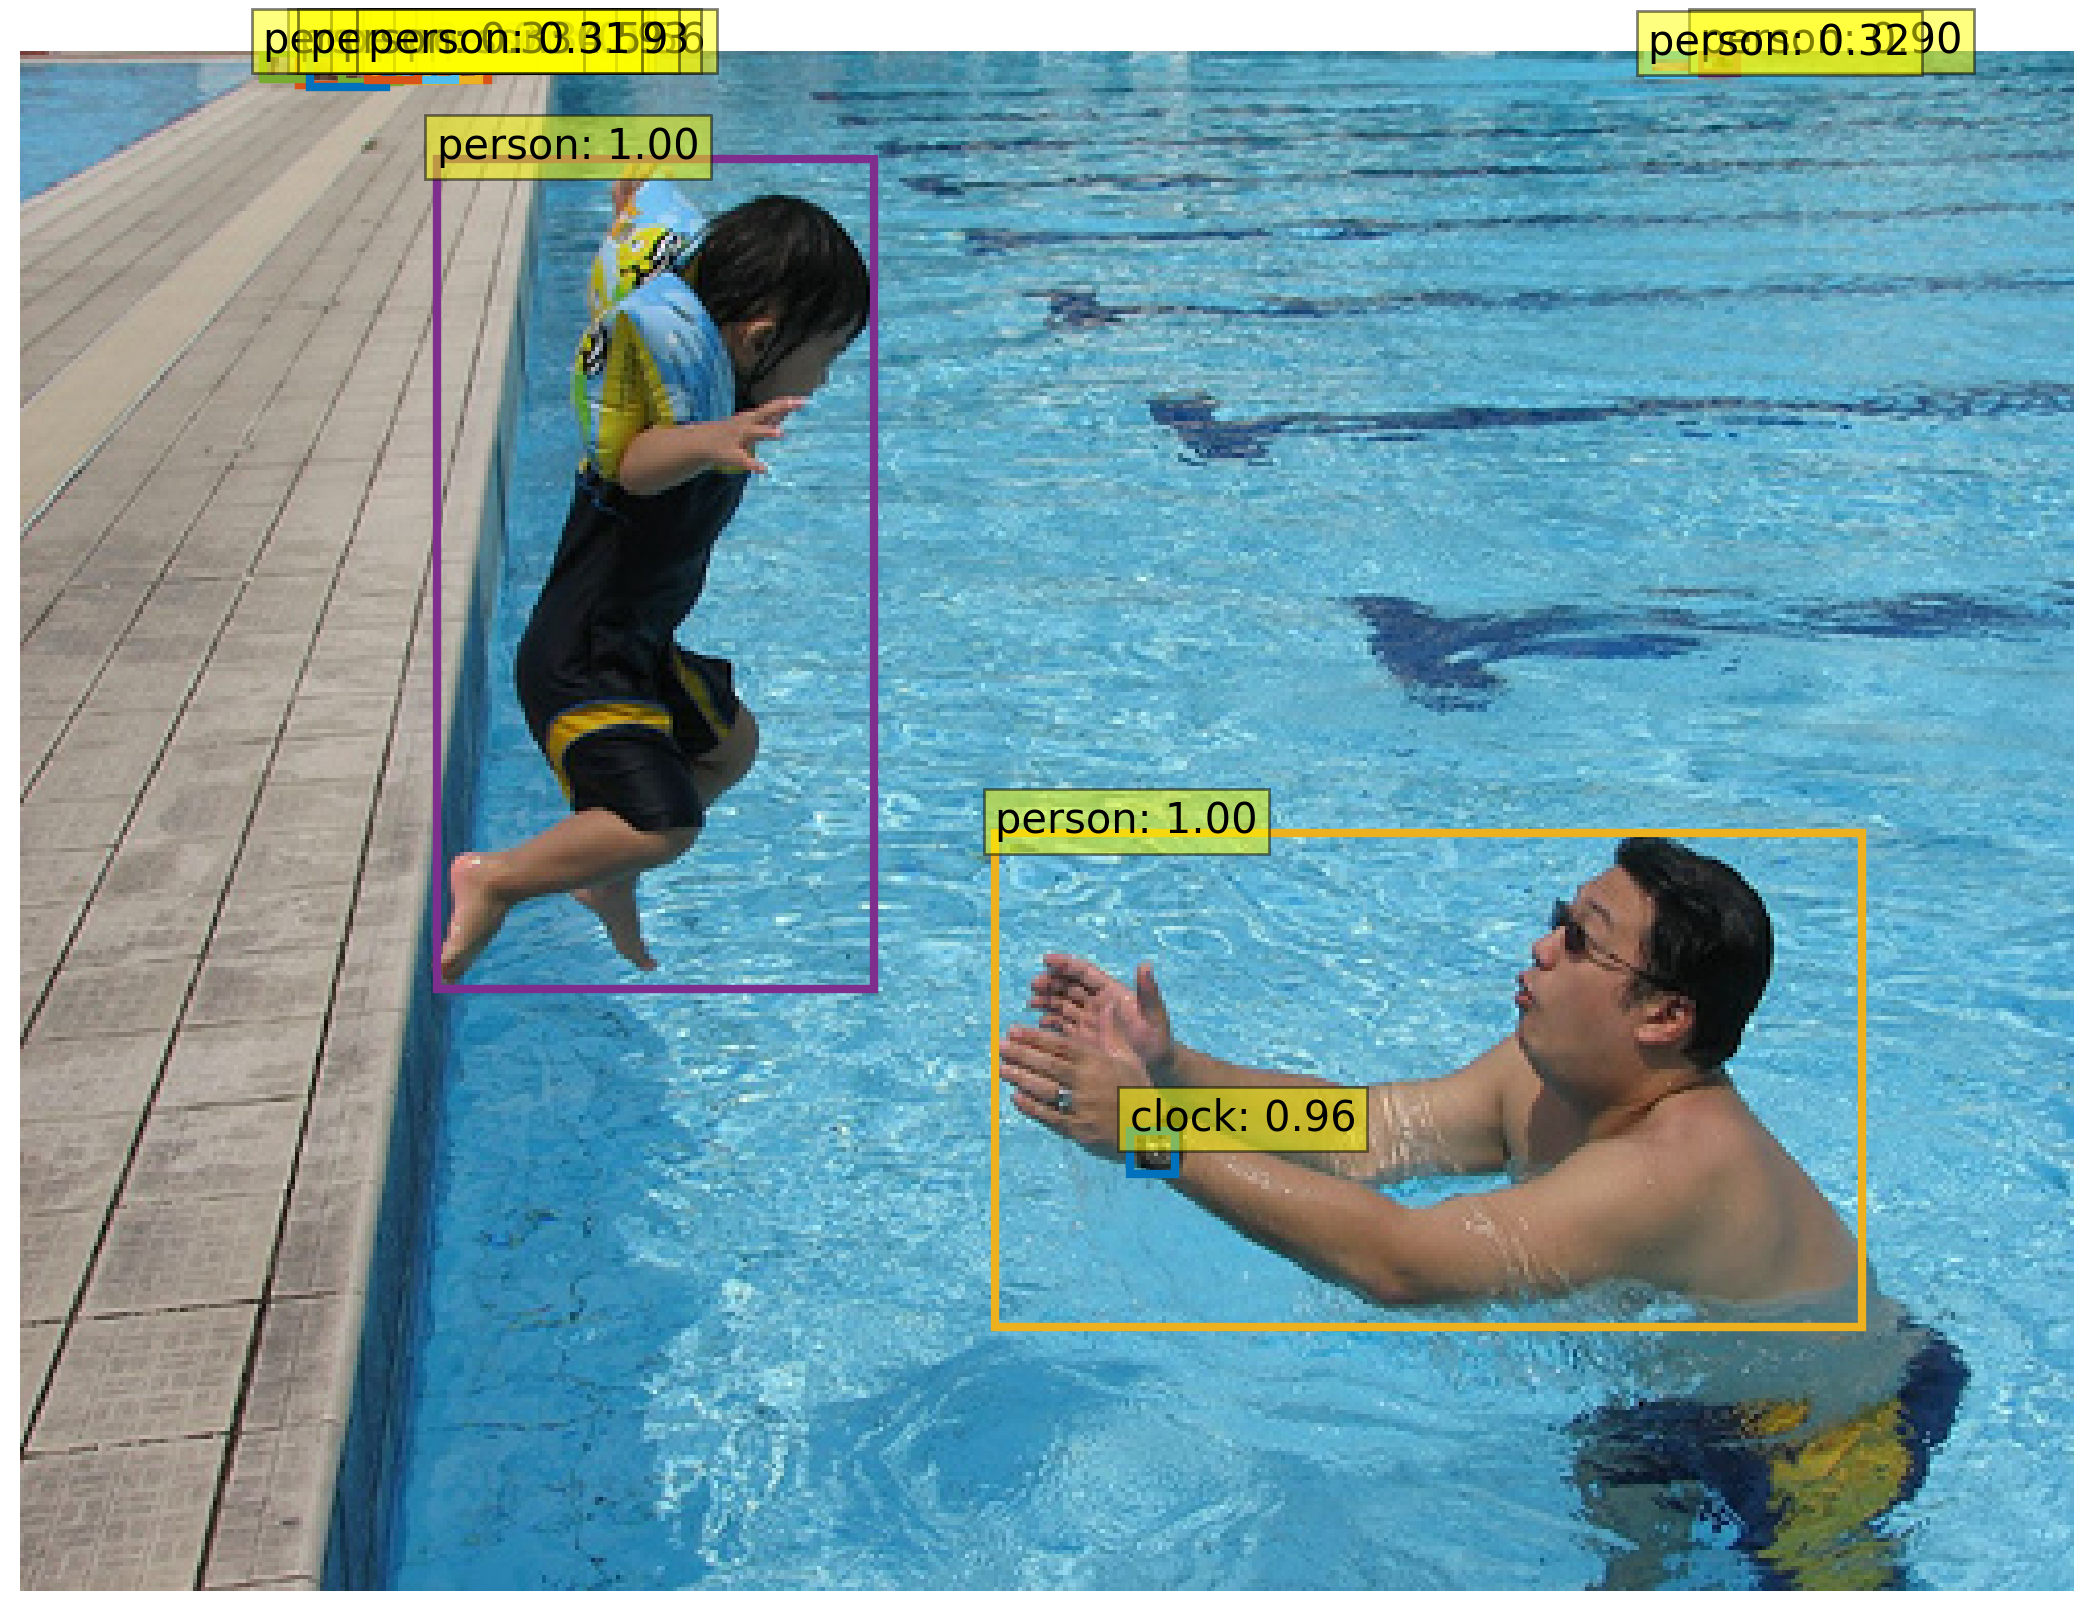

In [11]:
counter = 0

for imgp in reversed(sorted(os.listdir("/kaggle/input/pascalvoc2012-val/VOC2012/JPEGImages"))):
    print(imgp)
    im = Image.open(f"/kaggle/input/pascalvoc2012-val/VOC2012/JPEGImages/{imgp}")
    img = transform(im).unsqueeze(0)
    outputs = model(img)
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.3
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    get = plot_results(im, probas[keep], bboxes_scaled)
    counter+=1
    if counter==1:
        break

In [ ]:
# !wget https://karpathy.github.io/assets/obamafunny.jpg

In [ ]:
# im = Image.open("/kaggle/working/obamafunny.jpg")
# img = transform(im).unsqueeze(0)
# outputs = model(img)
# probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
# keep = probas.max(-1).values > 0.9
# bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
# get = plot_results(im, probas[keep], bboxes_scaled)

In [12]:
idx_to_class = {i: COCO_CLASSES[i] for i in range(len(COCO_CLASSES))}
voc_idx_to_class = {i: VOC_CLASSES[i] for i in range(len(VOC_CLASSES))}

In [14]:
!pip install tidecv

In [20]:
import tidecv
tide = tidecv.TIDE()


def convert(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return obj

counter = 0

predictions = []
ground_truths = []

counter=0
for image in reversed(sorted(os.listdir('/kaggle/input/pascalvoc2012-val/VOC2012/JPEGImages'))):
    image_id = image.split('.')[0]
    im = Image.open(f"/kaggle/input/pascalvoc2012-val/VOC2012/JPEGImages/{image}")
    img = transform(im).unsqueeze(0)
    outputs = model(img)
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.9
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    get = get_results(im, probas[keep], bboxes_scaled)
    extracted_objects = extract_objects(f"/kaggle/input/pascalvoc2012-val/VOC2012/Annotations/{image_id}.xml")
    
    #get the height and width of the image
    img = Image.open(f"/kaggle/input/pascalvoc2012-val/VOC2012/JPEGImages/{image}")
    width, height = img.size
    
    
    # Convert the bounding boxes to the format expected by TIDE
    pred_bboxes = [{'image_id': image_id, 'category_id': VOC_CLASSES.index(pred['name']), 'bbox': [float(coord) for coord in pred['bbox']], 'score': float(pred['score'])} for pred in get]
    gt_bboxes = [{'image_id': image_id, 'category_id': VOC_CLASSES.index(gt['name']), 'bbox': [int(coord) for coord in gt['bbox']],"segmentation":[[0]],"iscrowd":None,"width":width,"height":height} for gt in extracted_objects]
        
    predictions.extend(pred_bboxes)
    ground_truths.extend(gt_bboxes)
    
    counter+=1
    if counter==200:
        break
    
    
workaround_list = []
workaround_list.extend({"id": gt["image_id"].split("_")[0] + "_" + gt["image_id"].split("_")[1],"file_name":gt["image_id"] + ".jpg","width":gt["width"],"height":gt["height"]} for gt in ground_truths)
gt_dict = {"images":workaround_list,'annotations': ground_truths}
    
predictions_json = json.dumps(predictions, indent=4)
ground_truths_json = json.dumps(ground_truths, indent=4)
gt_new = json.dumps(gt_dict, indent=4)

# Saving the JSON data to files
with open("predictions.json", "w") as pred_file:
    pred_file.write(predictions_json)

with open("ground_truths.json", "w") as gt_file:
    gt_file.write(ground_truths_json)
    
# save the workaround list
with open("gt.json", "w") as f:
    f.write(gt_new)

In [16]:
# %load /opt/conda/lib/python3.10/site-packages/tidecv/datasets.py
# %load /opt/conda/lib/python3.10/site-packages/tidecv/datasets.py
from .data import Data
from . import functions as f

import zipfile
from pathlib import Path
from appdirs import user_data_dir
import urllib.request
from collections import defaultdict
import shutil
import json
import os

def default_name(path:str) -> str:
	return os.path.splitext(os.path.basename(path))[0]

def get_tide_path():
	if 'TIDE_PATH' in os.environ:
		tide_path = os.environ['TIDE_PATH']
	else:
		tide_path = user_data_dir('tidecv', appauthor=False)

	if not os.path.exists(tide_path):
		os.makedirs(tide_path)
	
	return tide_path

def download_annotations(name:str, url:str, force_download:bool=False) -> str:
	tide_path = get_tide_path()
	candidate_path = os.path.join(tide_path, name)
	finished_file_path = os.path.join(candidate_path, '_finished')
	zip_file_path = os.path.join(candidate_path, '_tmp.zip')

	# Check if the file has already been downloaded
	# If there isn't a file called _finished, that means we didn't finish downloading last time, so try again
	already_downloaded = os.path.exists(candidate_path) and os.path.exists(finished_file_path)

	if not force_download and already_downloaded:
		return candidate_path
	else:
		print('{} annotations not found. Downloading...'.format(name))
		
		if os.path.exists(candidate_path):
			shutil.rmtree(candidate_path)
		os.makedirs(candidate_path)

		urllib.request.urlretrieve(url, zip_file_path)
		with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
			zip_ref.extractall(candidate_path)

		os.remove(zip_file_path)
		open(finished_file_path, 'a').close() # Make an empty _finished file to mark that we were successful

		print('Successfully downloaded {} to "{}"'.format(name, candidate_path))
		return candidate_path





def COCO(path:str=None, name:str=None, year:int=2017, ann_set:str='val', force_download:bool=False) -> Data:
	"""
	Loads ground truth from a COCO-style annotation file.
	
	If path is not specified, this will download the COCO annotations for the year and ann_set specified.
	Valid years are 2014, 2017 and valid ann_sets are 'val' and 'train'.
	"""
	if path is None:
		path = download_annotations(
			'COCO{}'.format(year),
			'http://images.cocodataset.org/annotations/annotations_trainval{}.zip'.format(year),
			force_download)

		path = os.path.join(path, 'annotations', 'instances_{}{}.json'.format(ann_set, year))
	
	if name is None: name = default_name(path)
	
	with open(path, 'r') as json_file:
		cocojson = json.load(json_file)
	
	images = cocojson['images']
	anns   = cocojson['annotations']
	cats   = cocojson['categories'] if 'categories' in cocojson else None


	# Add everything from the coco json into our data structure
	data = Data(name, max_dets=100)

	image_lookup = {}

	for idx, image in enumerate(images):
		image_lookup[image['id']] = image
		data.add_image(image['id'], image['file_name'])

	if cats is not None:
		for cat in cats:
			data.add_class(cat['id'], cat['name'])

	for ann in anns:
		image  = ann['image_id']
		_class = ann['category_id']
		box    = ann['bbox']
		mask   = None
		
		if ann['iscrowd']: data.add_ignore_region(image, _class, box, mask)
		else:              data.add_ground_truth (image, _class, box, mask)
	
	return data

def COCOResult(path:str, name:str=None) -> Data:
	""" Loads predictions from a COCO-style results file. """
	if name is None: name = default_name(path)
	
	with open(path, 'r') as json_file:
		dets = json.load(json_file)

	data = Data(name)

	for det in dets:
		image = det['image_id']
		_cls  = det['category_id']
		score = det['score']
		box   = det['bbox']         if 'bbox'         in det else None
		mask  = det['segmentation'] if 'segmentation' in det else None

		data.add_detection(image, _cls, score, box, mask)
	
	return data
	


def LVIS(path:str=None, name:str=None, version_str:str='v1', force_download:bool=False) -> Data:
	"""
	Load an LVIS-style dataset.
	The version string is used for downloading the dataset and should be one of the versions of LVIS (e.g., v0.5, v1).

	Note that LVIS evaulation is special, but we can emulate it by adding ignore regions.
	The detector isn't punished for predicted class that LVIS annotators haven't guarenteed are in
	the image (i.e., the sum of GT annotated classes in the image and those marked explicitly not
	in the image.) In order to emulate this behavior, add ignore region labels for every class not
	found to be in the image. This is not that inefficient because ignore regions are separate out
	during mAP calculation and error processing, so adding a bunch of them doesn't hurt.
	
	The LVIS AP numbers are slightly lower than what the LVIS API reports because of these workarounds.
	"""
	if path is None:
		path = download_annotations(
			'LVIS{}'.format(version_str),
			'https://s3-us-west-2.amazonaws.com/dl.fbaipublicfiles.com/LVIS/lvis_{}_val.json.zip'.format(version_str),
			force_download)

		path = os.path.join(path, 'lvis_{}_val.json'.format(version_str))
		
	
	if name is None: name = default_name(path)
	

	with open(path, 'r') as json_file:
		lvisjson = json.load(json_file)
	
	images = lvisjson['images']
	anns   = lvisjson['annotations']
	cats   = lvisjson['categories'] if 'categories' in lvisjson else None

	data = Data(name, max_dets=300)
	image_lookup = {}
	classes_in_img = defaultdict(lambda: set())

	for image in images:
		image_lookup[image['id']] = image
		data.add_image(image['id'], image['coco_url']) # LVIS has no image names, only coco urls

		# Negative categories are guarenteed by the annotators to not be in the image.
		# Thus we should care about them during evaluation.
		for cat_id in image['neg_category_ids']:
			classes_in_img[image['id']].add(cat_id)

	if cats is not None:
		for cat in cats:
			data.add_class(cat['id'], cat['synset'])

	for ann in anns:
		image  = ann['image_id']
		_class = ann['category_id']
		box    = ann['bbox']
		mask   = f.toRLE(ann['segmentation'], image_lookup[image]['width'], image_lookup[image]['height'])
		
		data.add_ground_truth(image, _class, box, mask)

		# There's an annotation for this class, so we should consider the class for evaluation.
		classes_in_img[image].add(_class)

	all_classes = set(data.classes.keys())

	# LVIS doesn't penalize the detector for detecting classes that the annotators haven't guarenteed to be in/out of
	# the image. Here we simulate that property by adding ignore regions for all such classes.
	for image in images:
		ignored_classes = all_classes.difference(classes_in_img[image['id']])

		# LVIS doesn't penalize the detector for mistakes made on classes explicitly marked as not exhaustively annoted
		# We can emulate this by adding ignore regions for every category listed, so add them to the ignored classes.
		ignored_classes.update(set(image['not_exhaustive_category_ids']))

		for _cls in ignored_classes:
			data.add_ignore_region(image['id'], _cls)

	return data

def LVISResult(path:str, name:str=None) -> Data:
	""" Loads predictions from a LVIS-style results file. Note that this is the same as a COCO-style results file. """
	return COCOResult(path, name)


def Pascal(path:str=None, name:str=None, year:int=2007, ann_set:str='val', force_download:bool=False) -> Data:
	"""
	Loads the Pascal VOC 2007 or 2012 data from a COCO json.
	
	Valid years are 2007 and 2012, and valid ann_sets are 'train' and 'val'.
	"""
	if path is None:
		path = download_annotations(
			'Pascal',
			'https://s3.amazonaws.com/images.cocodataset.org/external/external_PASCAL_VOC.zip',
			force_download)
		
		path = os.path.join(path, 'PASCAL_VOC', 'pascal_{}{}.json'.format(ann_set, year))

	return COCO(path, name)



def Cityscapes(path:str, name:str=None):
	"""
	Loads the fine cityscapes annotations as instance segmentation masks, and also generates bounding boxes for them.

	Note that we can't automatically download Cityscapes because it requires registration and an agreement to the ToS.
	You can get cityscapes here: https://www.cityscapes-dataset.com/

	Path should be to gtFine/<ann_set>. E.g., <path_to_cityscapes>/gtFine/val.
	"""
	if name is None: name = default_name(path)
	data = Data(name)

	instance_classes = {
		'person'    : 24,
		'rider'     : 25,
		'car'       : 26,
		'truck'     : 27,
		'train'     : 31,
		'motorcycle': 32,
		'bicycle'   : 33,
		'bus'       : 28,
		'caravan'   : 29,
		'trailer'   : 30,
	}

	ignored_classes = set([29, 30])

	for class_name, class_id in instance_classes.items():
		data.add_class(class_id, class_name)

	for ann in Path(path).glob('*/*.json'):
		with open(ann) as json_file:
			ann_json = json.load(json_file)

		# Note: a string for an image ID is okay
		image_id = os.path.basename(ann).replace('_gtFine_polygons.json', '')
		objs = ann_json['objects']

		data.add_image(image_id, image_id) # The id in this case is just the name of the image

		# Caravan and Trailer should be ignored from all evaluation
		for _cls in ignored_classes:
			data.add_ignore_region(image_id, _cls)

		for obj in objs:
			class_label = obj['label']
			is_crowd = False

			# Cityscapes labelers can label objects without defined boundaries as 'group'. In COCO-land this would be
			# a crowd annotation. So in this case, let's make it an ignore region.
			if class_label.endswith('group'):
				is_crowd = True
				class_label = class_label[:-5] # Remove the group at the end

			# We are only considering instance classes
			if not class_label in instance_classes:
				continue
			
			class_id = instance_classes[class_label]

			# If the class is not used in evaluation, don't include it
			if class_id in ignored_classes:
				continue
			
			poly = [sum(obj['polygon'], [])] # Converts a list of points to a list of lists of ints, where every 2 ints represents a point
			box  = f.polyToBox(poly)

			if is_crowd:
				data.add_ignore_region(image_id, class_id, box, poly)
			else:
				data.add_ground_truth(image_id, class_id, box, poly)

	return data






-- predictions --

bbox AP @ [50-95]: 6.82
                                         bbox AP @ [50-95]
  Thresh       50       55       60       65       70       75       80       85       90       95  
---------------------------------------------------------------------------------------------------
    AP       7.38     7.36     7.30     7.30     7.30     7.30     7.16     6.77     6.19     4.13  

                         Main Errors
  Type      Cls      Loc     Both     Dupe      Bkg     Miss  
-------------------------------------------------------------
   dAP     0.00     0.89     0.82     0.06     1.78     0.20  

        Special Error
  Type   FalsePos   FalseNeg  
-----------------------------
   dAP       2.13       0.34  



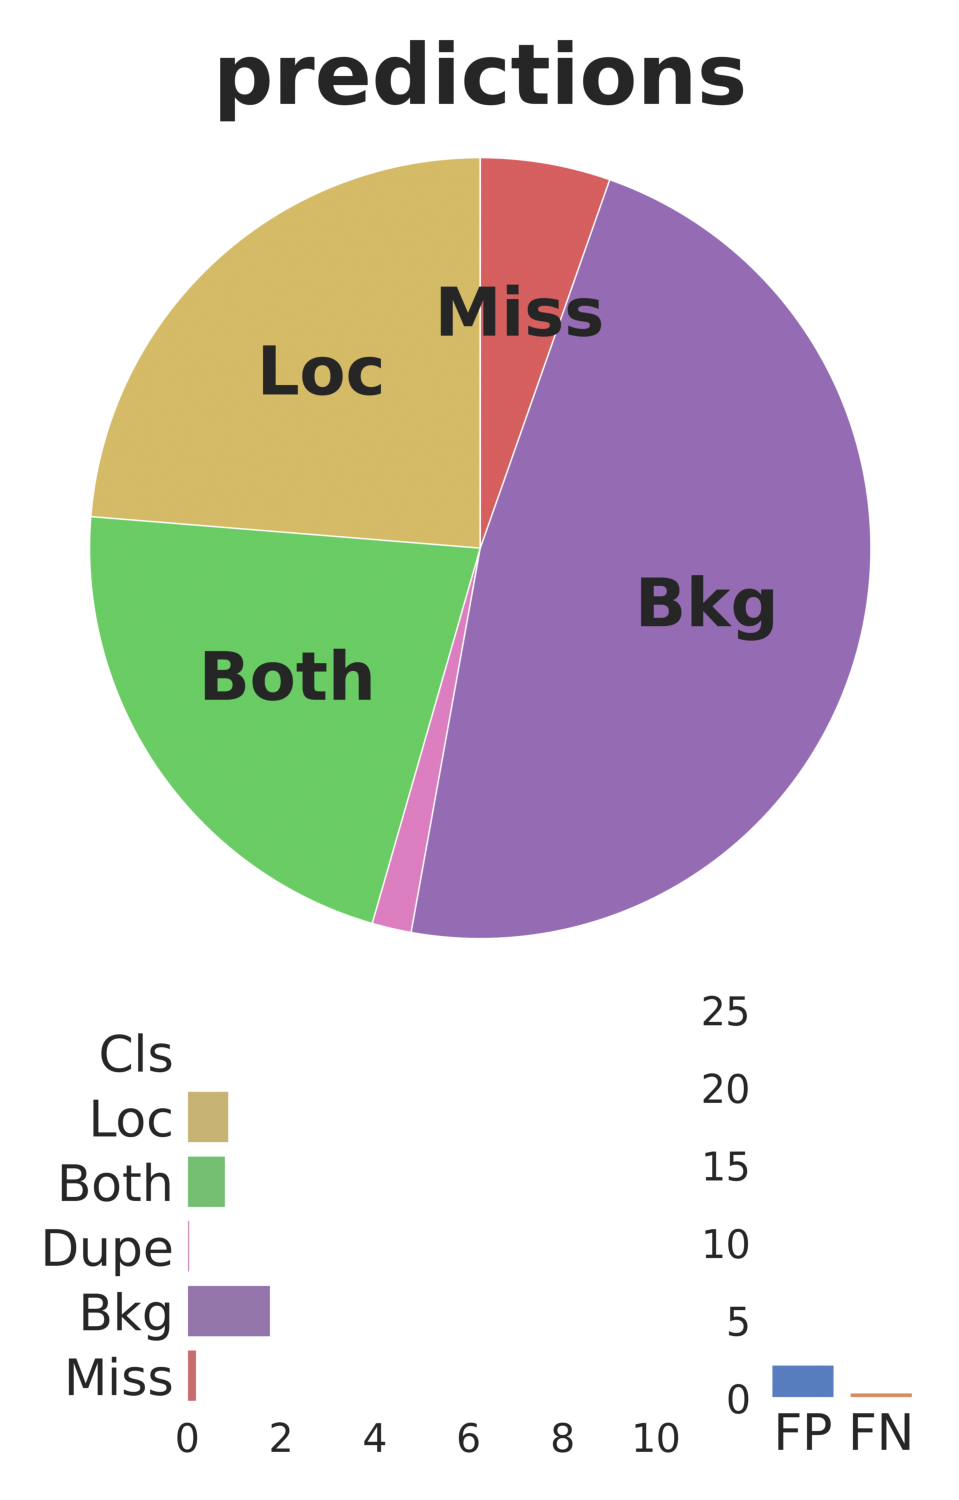

In [21]:
# Import the TIDE evaluation toolkit
from tidecv import TIDE

# Import the datasets we want to use
import tidecv.datasets as datasets

gt = datasets.COCO(path = 'gt.json')

bbox_file = "predictions.json"
bbox_results = datasets.COCOResult(bbox_file)

tide = TIDE()

tide.evaluate_range(gt, bbox_results, mode=TIDE.BOX)
tide.summarize()
tide.plot()